Nesse notebook temos o objetivo de modelar nosso dados seguindo o modelo ARIMA. Vamos explicar por que usar esse modelo e como achamos seus parâmetros.

O modelo ARIMA como dito em notebooks anteriores é um modelo que integra os modelos AutoRegressivos AR e modelos de média móveis MA. ARIMA é uma modelagem bem robusto e possui 3 parâmetros: 

* d: número de derivações usadas para série ser estacionária
* p (AutoRegressivo): quantos valores passados influenciam o atual
* q (Média Móvel): quantos erros passados influenciam no valor atual

Certo, mas como descobrimos esses parâmetros? 

Para o parâmetro **D** usamos um teste ADF, esse é um teste que nos diz se a série é estácionária ou não usando testes de hipótese. Então devemos derivar nossa série original tantas vezes quanto necessário para o teste ADF ser capaz de rejeitar H0 (dizer que a série é sim estacionária).

Já nos parâmetros **P** e **Q** usamos das funções apresentadas no notebook anterior ACF E PACF. E qual a utilidade dessas funções? 

Na função **PACF** temos a influência direta de valores passados para o nosso valor atual, ou seja, é exatamente o P que estámos procurando. 

Já a função **ACF** mostra a influência acumulada de valores passados com nosso valor atual, justamente o Q que procuramos. 

Porém no módulo passado usamos a série original e de forma crua. Para conseguirmos um modelo ARIMA mais acertivo precisamos transformar nossa série em estacionária primeiro.

In [ ]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


btc = yf.download("BTC-USD", period="max")
close = btc['Close'].dropna()

# Vamos começar testando a função para os dados originais
# Se nosso p-valor for maior do que 0.05 derivamos e repetimos o processo


print('ADF nível (p-valor):', adfuller(close)[1])  # ADF na série original
print('ADF 1ª diferença (p-valor):', adfuller(close.diff().dropna())[1])  # ADF com uma derivação

Baixando dados para BTC-USD...


C:\Users\kaueo\AppData\Local\Temp\ipykernel_3616\2292537363.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download(TICKER, period='max', interval='1d')
[*********************100%***********************]  1 of 1 completed


Total de dias: 4091
Treino: 3272 dias | Teste (Previsão): 819 dias
--------------------------------------------------
Treinando modelo inicial (Auto ARIMA)... Aguarde...
Modelo treinado: (2, 1, 2) em 41.3 segundos

Iniciando previsão dia-a-dia. Isso pode demorar um pouco...
Processado: 50/819 dias (6.1%)


Podemos notar que já na primeira derivação o p-valor é praticamente 0, ou seja, **D** = 1.

Agora que a série com uma derivação é estacionária vamos aplicar as funções ACF e PACF: 

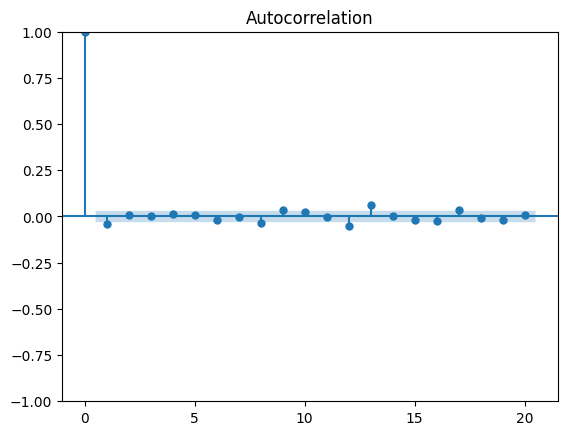

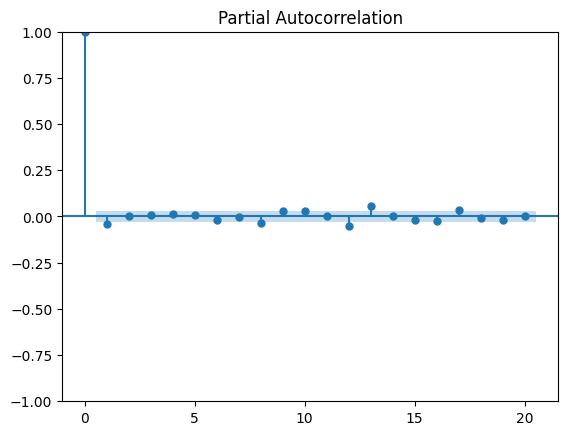

In [10]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

est = close.diff().dropna()

plot_acf(est, lags=20)
plt.show()

plot_pacf(est, lags=20)
plt.show()


C:\Users\kaueo\AppData\Local\Temp\ipykernel_15752\678325326.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download('BTC-USD', period='2y', interval='1d')
[*********************100%***********************]  1 of 1 completed


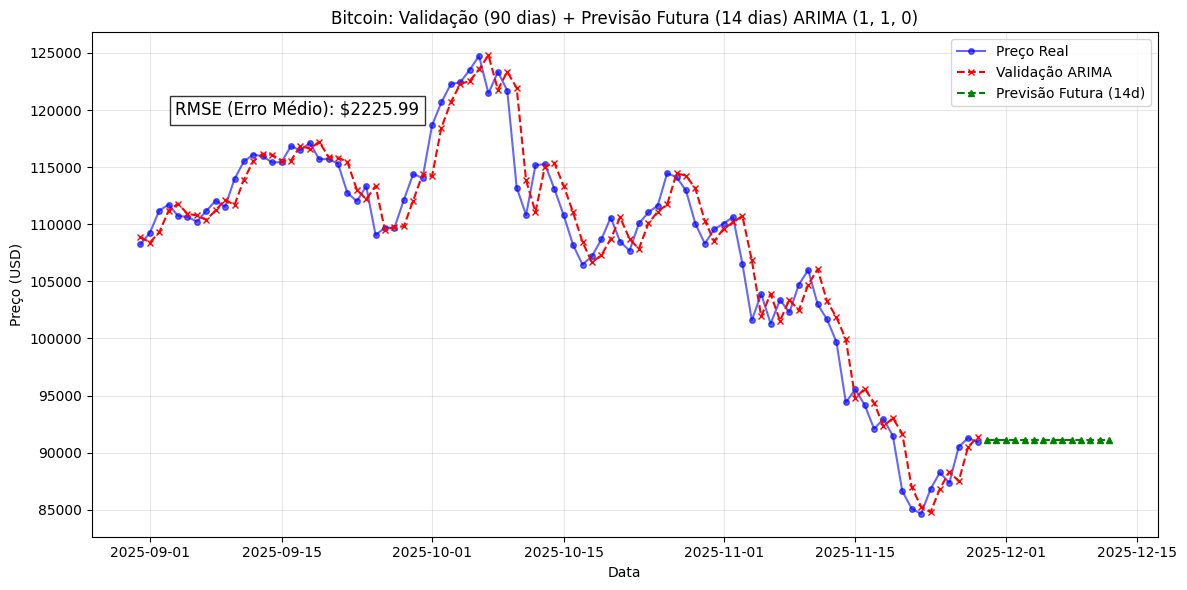

In [8]:
import yfinance as yf
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta

TEST_DAYS = 90
PRED_DAYS = 14

btc_data = yf.download('BTC-USD', period='2y', interval='1d')

if isinstance(btc_data.columns, pd.MultiIndex):
    btc_data = btc_data['Close']['BTC-USD']
else:
    btc_data = btc_data['Close']

btc_data = btc_data.dropna()

train = btc_data[:-TEST_DAYS]
test = btc_data[-TEST_DAYS:]

model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)

full_forecasts = []

for i in range(len(test)):
    output = model.predict(n_periods=1)
    pred_value = output.iloc[0] if isinstance(output, pd.Series) else output[0]
    full_forecasts.append(pred_value)

    true_value = test.iloc[i]
    model.update([true_value], maxiter=5)

for i in range(PRED_DAYS):
    output = model.predict(n_periods=1)
    pred_value = output.iloc[0] if isinstance(output, pd.Series) else output[0]
    full_forecasts.append(pred_value)


forecast_test = full_forecasts[:len(test)]
forecast_future = full_forecasts[len(test):]

last_date = test.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1),
                             periods=PRED_DAYS)

plt.figure(figsize=(12, 6))
plt.plot(test.index,
         test, label='Preço Real',
         color='blue', marker='o',
         markersize=4, alpha=0.6)

plt.plot(test.index,
         forecast_test,
         label='Validação ARIMA',
         color='red', linestyle='--',
         marker='x',
         markersize=4)

plt.plot(future_dates,
         forecast_future,
         label='Previsão Futura (14d)',
         color='green', linestyle='--',
         marker='^', markersize=4)

plt.title(f'Bitcoin: Validação (90 dias) + Previsão Futura (14 dias) ARIMA {model.order}')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# --- 7. Cálculo do Erro (Apenas sobre a parte de teste) ---
rmse = np.sqrt(np.mean((test.values - forecast_test) ** 2))

plt.figtext(0.15, 0.8, 
            f"RMSE (Erro Médio): ${rmse:.2f}", 
            fontsize=12, 
            bbox={"facecolor": "white", "alpha": 0.8})

plt.tight_layout()
plt.show()

Podemos observar duas coias com esse gráfico, que o modelo ARIMA auto treinado usou valores que prevemos nos testes passados e que o modelo ARIMA é muito bom para prever dados a curto prazo com uma distância de um ou dois para os dados reais, mas quando essa referência se perde podemos ver que o ARIMA se perde rapidamente. 

### Pontos positivos
* Funciona bem para previsões próximas
* Fácil de treinar e de usar os valores das funções
* Erro quadrático foi significantemente baixo

### Pontos negativos
* Perde a precisão muito rápido
* Fica lento com um grande volume de testes
* Precisa do apoio dos dados reais para se manter